In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/TCC/multiclass-dataset.zip

In [4]:
!mkdir ndataset
!mkdir ndataset/malignant
!mkdir ndataset/benign
!mkdir ndataset/normal

In [5]:
!mkdir dataset
!mv benign dataset
!mv malignant dataset
!mv normal dataset

In [6]:
import os
from PIL import Image

dataset_dir = 'dataset'
ndataset_dir = 'ndataset'

for class_name in ['malignant', 'benign', 'normal']:
    class_dir = os.path.join(ndataset_dir, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            if os.path.isfile(image_path):
                image = Image.open(image_path)
                new_image = image.resize((224, 224))
                save_dir = os.path.join(ndataset_dir, class_name)
                save_path = os.path.join(save_dir, image_file)
                new_image.save(save_path)

In [7]:
directory = '/content/ndataset'

categories = ['benign', 'malignant', 'normal']

In [8]:
import cv2
import random
import os
import numpy as np
from collections import Counter

data = []
img_size = 224

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [9]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)
X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)

X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

In [10]:
from keras.models import Sequential
from keras.applications import ResNet50

X_train_rgb = np.repeat(X_train, 3, axis=3)
X_valid_rgb = np.repeat(X_valid, 3, axis=3)

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(16))
model.add(layers.Rescaling(1.0 / 255))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 rescaling (Rescaling)       (None, 16)                0         
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 batch_normalization (BatchN  (None, 16)               64

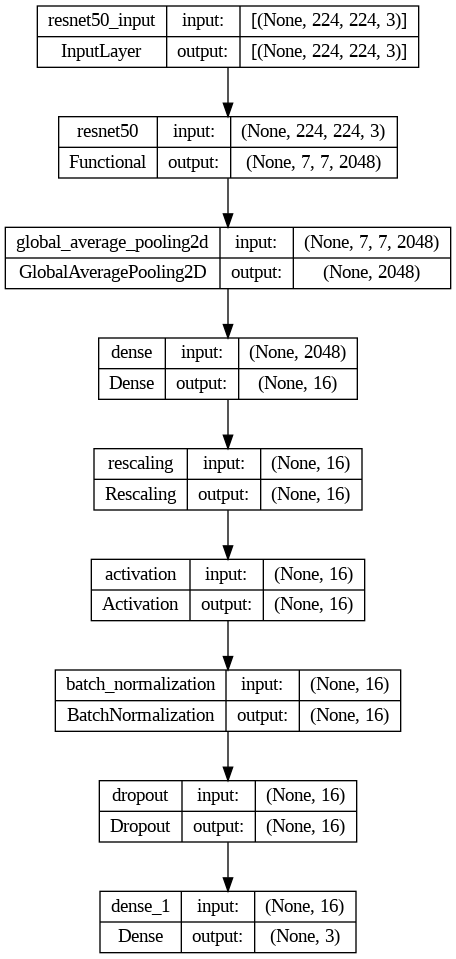

In [11]:
keras.utils.plot_model(model, show_shapes=True)

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-5), metrics=['accuracy'])

In [13]:
history = model.fit(X_train_rgb, y_train, batch_size=8, epochs=35, validation_data=(X_valid_rgb, y_valid))

Epoch 1/35
103/103 [==============================] - 68s 150ms/step - loss: 0.9881 - accuracy: 0.6642 - val_loss: 1.0937 - val_accuracy: 0.5127
Epoch 2/35
103/103 [==============================] - 11s 107ms/step - loss: 0.8032 - accuracy: 0.7640 - val_loss: 1.0821 - val_accuracy: 0.5127
Epoch 3/35
103/103 [==============================] - 11s 111ms/step - loss: 0.6762 - accuracy: 0.7871 - val_loss: 1.0730 - val_accuracy: 0.5127
Epoch 4/35
103/103 [==============================] - 11s 109ms/step - loss: 0.5885 - accuracy: 0.8358 - val_loss: 1.0506 - val_accuracy: 0.5127
Epoch 5/35
103/103 [==============================] - 12s 113ms/step - loss: 0.5445 - accuracy: 0.8613 - val_loss: 1.0373 - val_accuracy: 0.5127
Epoch 6/35
103/103 [==============================] - 11s 111ms/step - loss: 0.4839 - accuracy: 0.8942 - val_loss: 1.0256 - val_accuracy: 0.5127
Epoch 7/35
103/103 [==============================] - 12s 113ms/step - loss: 0.4244 - accuracy: 0.9282 - val_loss: 1.0669 - val_ac

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_valid_rgb, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 4s 189ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        30
           1       1.00      1.00      1.00       141
           2       1.00      0.98      0.99       104

    accuracy                           0.99       275
   macro avg       0.98      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275

[[ 30   0   0]
 [  0 141   0]
 [  2   0 102]]


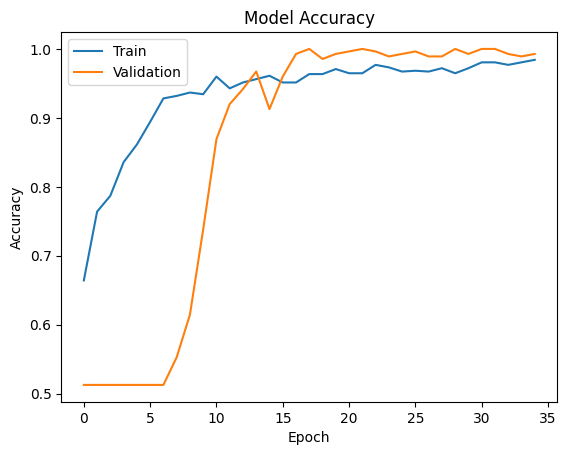

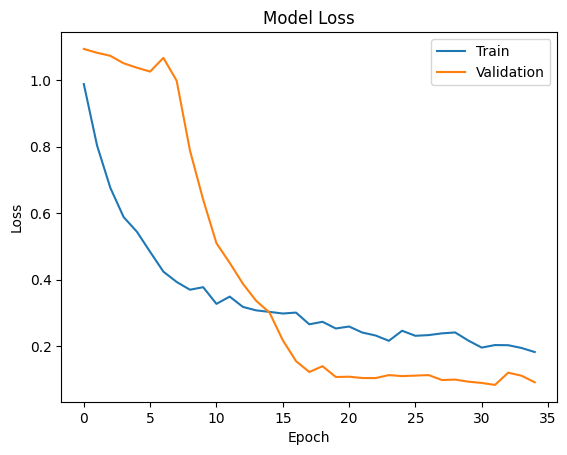

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()